In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Conv2D, MaxPool2D
from keras.utils import clear_session, to_categorical
from keras.callbacks import EarlyStopping
from keras import Model
from keras.optimizers import RMSprop
from sklearn.metrics import f1_score, classification_report, ConfusionMatrixDisplay
import pickle as pkl

In [2]:
def carregar_dados(nome):
    Xnome = "X_%s.pkl" % (nome)
    ynome = "y_%s.pkl" % (nome)
    with open(Xnome, "rb") as f:
        X = pkl.load(f)
    with open(ynome, "rb") as f:
        y = pkl.load(f)
    return X, y

In [3]:
X_treino, y_treino = carregar_dados("treino")
X_teste, y_teste = carregar_dados("teste")
X_val, y_val = carregar_dados("val")
X_treino.shape, y_treino.shape, X_val.shape, y_val.shape, X_teste.shape, y_teste.shape

((280, 32, 32), (280,), (40, 32, 32), (40,), (80, 32, 32), (80,))

In [4]:
y_treino = to_categorical(y_treino)
y_val = to_categorical(y_val)
y_treino.shape, y_val.shape

((280, 40), (40, 40))

# MLP

In [5]:
#"Tune" estes parâmetros

#Número de neurônios por camada. O número de elementos desta lista define o número de camadas ocultas da rede.
neuronios_por_camada = [200, 200, 200]
#Qual função de ativação utilizar em cada camada. Esta lista deve ter o mesmo número de entradas da lista "neuronios_por_camada"
ativacoes = ["sigmoid", "sigmoid", "sigmoid"]
#Taxa de aprendizagem.
taxa_aprendizagem = 0.001
#Número máximo de épocas (iterações) que devem ser executadas.
max_epocas = 300
#Número máximo de épocas que devem ser executadas caso não haja melhoria no conjunto de validação durante o treino.
paciencia_parada = 30

In [ ]:
clear_session()
entrada = Input(shape=(1024,))
for idx, (n_neuronios, func_ativ) in enumerate(zip(neuronios_por_camada, ativacoes)):
    if idx > 0:
        rede = Dense(n_neuronios, activation=func_ativ)(rede)
    else:
        rede = Dense(n_neuronios, activation=func_ativ)(entrada)
saida = Dense(40, activation="softmax")(rede)

In [7]:
modelo = Model(inputs=entrada, outputs=saida)
modelo.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 200)            │       205,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 40)             │         8,040 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 293,440 (1.12 MB)

 Trainable params: 293,440 (1.12 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
optimizer = RMSprop(learning_rate=taxa_aprendizagem)
modelo.compile(optimizer=optimizer,loss="categorical_crossentropy")

In [ ]:
ES = EarlyStopping(patience=paciencia_parada, restore_best_weights=True)
curvas = modelo.fit(X_treino.reshape((-1,1024)), 
                    y_treino, 
                    epochs=max_epocas,
                    callbacks=[ES],
                    validation_data=(X_val.reshape((-1,1024)), y_val), 
                    verbose=1, shuffle=True)

O modelo foi treinado por 300 épocas. Menor erro no conjunto de validação: 0.305


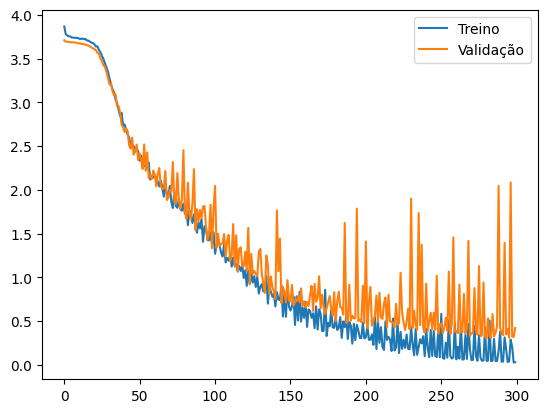

In [10]:
print("O modelo foi treinado por %d épocas. Menor erro no conjunto de validação: %.3f" % (len(curvas.epoch), min(curvas.history["val_loss"])))
plt.plot(curvas.history["loss"], label="Treino")
plt.plot(curvas.history["val_loss"], label="Validação")
plt.legend()

In [ ]:
#Realizar as predições no conjunto de testes. A saída para cada imagem é um vetor de probabilidades, contendo
#a probabilidade da entrada pertencer a cada uma das n classes.
pred_prob = modelo.predict(X_teste.reshape((-1,1024)))

In [12]:
#Predição única na classe com maior probabilidade
pred = np.argmax(pred_prob, axis=1)

In [13]:
print("F1-score médio: %.3f" % f1_score(y_teste, pred, average="macro"))

F1-score médio: 0.714


In [14]:
print(classification_report(y_teste, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       1.00      0.50      0.67         2
           2       1.00      0.50      0.67         2
           3       1.00      0.50      0.67         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       0.50      0.50      0.50         2
           7       0.50      0.50      0.50         2
           8       0.67      1.00      0.80         2
           9       1.00      1.00      1.00         2
          10       1.00      0.50      0.67         2
          11       1.00      0.50      0.67         2
          12       0.50      0.50      0.50         2
          13       0.67      1.00      0.80         2
          14       0.67      1.00      0.80         2
          15       1.00      0.50      0.67         2
          16       1.00      0.50      0.67         2
          17       0.50    